In [2]:
!pip install torchsummary

In [1]:
!pip install torchvision


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
import warnings
import os
import sys
from tqdm import tqdm
import cv2

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
RESOLUTION = 224

In [14]:
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

In [15]:
import os
import cv2
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import functional as F
from tqdm import tqdm
from typing import Callable, Any

# Define the resolution
RESOLUTION = 224

# Custom data augmentation functions
def random_horizontal_flip(image: Image.Image) -> Image.Image:
    if torch.rand(1) < 0.5:
        image = F.hflip(image)
    return image

def random_rotation(image: Image.Image) -> Image.Image:
    angle = torch.randint(-10, 10, (1,))
    image = F.rotate(image, angle.item())
    return image

# Define the transformation pipeline including multiple data augmentations
transformer = transforms.Compose([
    random_horizontal_flip,
    random_rotation,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.Resize((RESOLUTION, RESOLUTION))
])

In [16]:
import torch
import matplotlib.pyplot as plt

def plot_image_from_list(images, labels, count):
    fig, axes = plt.subplots(1, count, figsize=(15, 3))
    for i in range(count):
        img = images[i]
        if img.dim() == 3:  # Check if the image is RGB (CHW format)
            img = img.permute(1, 2, 0)  # Convert from CHW to HWC format
        elif img.dim() == 2:  # Grayscale image
            img = img.numpy()  # Convert torch.Tensor to numpy array
            axes[i].imshow(img, cmap="gray")
        else:
            raise RuntimeError("Unsupported image format")
        
        axes[i].set_xlabel(labels[i])
        axes[i].set_xticks([]), axes[i].set_yticks([])  # Hide ticks
    plt.tight_layout()
    plt.show()


In [17]:
def plot_randomly_from_dataset(dataset):
    images = []
    labels = []
    for _ in range(25):
        index = torch.randint(0, len(dataset), (1,)).item()
        image, label = dataset[index]
        images.append(image.squeeze())
        labels.append(dataset.label_id2str(label.item()))

    plot_image_from_list(images, labels, 5)  

In [18]:
def plot_randomly_form_dataset_model(__dataset, __model):
    images = []
    labels = []
    for _ in range(25):
        index = torch.randint(0, len(__dataset), (1,)).item()
        image, label = __dataset[index]
        images.append(image.squeeze())
        result = __model(image.unsqueeze(dim=0).to(device)).squeeze().cpu().argmax()
        labels.append(__dataset.label_id2str(label.item()) + " -> " + __dataset.label_id2str(result.item()))

    plot_image_from_list(images, labels, 5) 

Data set loading and frame extraction

In [19]:
DATA_SOURCE = {
    "Abuse": "D:\\capstone\\trimmedds\\TrimedDataset\\Train\\Abuse",
    "Arrest": "D:\\capstone\\trimmedds\\TrimedDataset\\Train\\Arrest",
    "Arson": "D:\\capstone\\trimmedds\\TrimedDataset\\Train\\Arson",
    "Assault": "D:\\capstone\\trimmedds\\TrimedDataset\\Train\\Assault",
    "Explosion": "D:\\capstone\\trimmedds\\TrimedDataset\\Train\\Explosion",
    "Fighting": "D:\\capstone\\trimmedds\\TrimedDataset\\Train\\Fighting",
    "Normal": "D:\\capstone\\trimmedds\\TrimedDataset\\Train\\Normal"
}

In [27]:
class CrimeDataset(Dataset):
    def __init__(self, train=True, train_test_split=0.8, random_state=42):
        torch.manual_seed(random_state)
        
        self._data = []
        self._labels = []
        self._inclusion_probability = train_test_split if train else 1.0 - train_test_split
        self._frame_interval = 30
        
        print(f"Loading {'train' if train else 'test' } dataset...")
        for label, data_path in DATA_SOURCE.items():
            print(f"Loading Label {label}...")
            for file in tqdm(os.listdir(data_path)):
                if file.endswith(".mp4") and torch.rand(1).item() <= self._inclusion_probability:
                    path = os.path.join(data_path, file)
                    data, labels = self._parse_file(path, label)
                    self._data.extend(data)
                    self._labels.extend(labels)
        print(f"Finished loading {'train' if train else 'test' } dataset... Loaded  {len(self._data)} images.")
    
    def _parse_file(self, path, label):
        if not os.path.exists(path):
            return [], []
        
        data = []
        labels = []
        
        cap = cv2.VideoCapture(path)
        
        success, image = cap.read()
        while success:
            try:
                if True:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
                    Y, U, V = cv2.split(image)
                    image = transformer(Image.fromarray(Y))  # Apply augmentation pipeline here
                    data.append(image)
                    labels.append(label)
            except Exception as e:
                print(f"Error loading file {path}: {e}")
            
            count = 0
            while success and count < self._frame_interval:
                success, image = cap.read()
                count += 1
        return data, labels
        
    def label_str2id(self, label):
        labels = DATA_SOURCE.keys()
        return list(labels).index(label)

    def label_id2str(self, label):
        labels = DATA_SOURCE.keys()
        return list(labels)[label]
        
    def __len__(self):
        return len(self._labels)

    def __getitem__(self, idx):
        data = self._data[idx]
        label = self._labels[idx]
        return data, torch.tensor([self.label_str2id(label)])

In [28]:
train_dataset = CrimeDataset(True)
test_dataset = CrimeDataset(False)

Loading train dataset...
Loading Label Abuse...


  5%|████▍                                                                              | 3/56 [00:00<00:02, 25.54it/s]

Loading Label Arrest...


  4%|██▉                                                                                | 2/56 [00:00<00:04, 12.16it/s]

Loading Label Arson...


  2%|█▉                                                                                 | 2/84 [00:00<00:04, 18.82it/s]

Loading Label Assault...


  3%|██▊                                                                                | 2/58 [00:00<00:03, 15.79it/s]

Loading Label Explosion...


  6%|████▋                                                                             | 7/123 [00:00<00:01, 58.29it/s]

Loading Label Fighting...


  1%|▋                                                                                 | 1/120 [00:00<00:13,  8.94it/s]

Loading Label Normal...


 12%|█████████▊                                                                        | 11/92 [00:00<00:01, 75.29it/s]

Finished loading train dataset... Loaded  5050 images.
Loading test dataset...
Loading Label Abuse...


 14%|███████████▊                                                                       | 8/56 [00:00<00:00, 57.47it/s]

Loading Label Arrest...


 16%|█████████████▎                                                                     | 9/56 [00:00<00:00, 76.65it/s]

Loading Label Arson...


 18%|██████████████▋                                                                   | 15/84 [00:00<00:00, 85.98it/s]

Loading Label Assault...


  2%|█▍                                                                                 | 1/58 [00:00<00:05,  9.99it/s]

Loading Label Explosion...


 22%|█████████████████▌                                                              | 27/123 [00:00<00:00, 191.16it/s]

Loading Label Fighting...


  4%|███▍                                                                              | 5/120 [00:00<00:02, 43.83it/s]

Loading Label Normal...


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:01<00:00, 74.91it/s]

Finished loading test dataset... Loaded  1065 images.


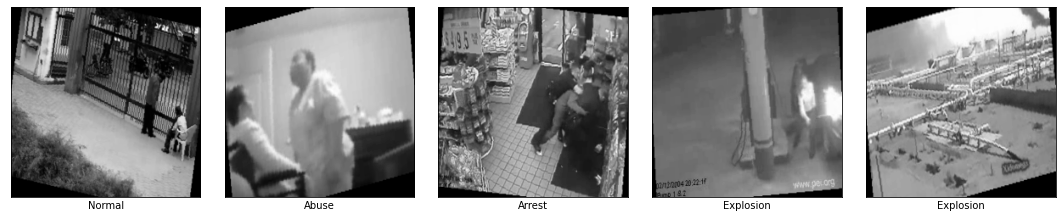

In [29]:
plot_randomly_from_dataset(test_dataset) #random frames

EDA

Total number of videos: 5050


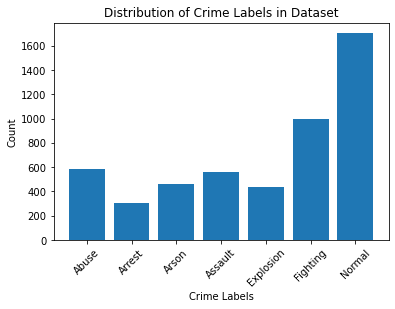

Total number of videos: 1065


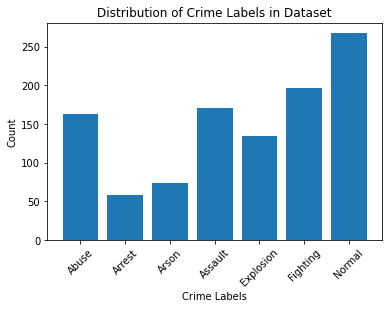

In [30]:
import matplotlib.pyplot as plt


def distribution(crime_dataset):
# Initialize the dataset

    # Basic dataset information
    print(f"Total number of videos: {len(crime_dataset)}")

    # Label distribution
    label_counts = {label: 0 for label in DATA_SOURCE.keys()}
    for label in crime_dataset._labels:
        label_str = label  # Assuming label is already a string
        label_counts[label_str] += 1

    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(6, 4))
    plt.bar(labels, counts)
    plt.xlabel('Crime Labels')
    plt.ylabel('Count')
    plt.title('Distribution of Crime Labels in Dataset')
    plt.xticks(rotation=45)
    plt.show()
    
distribution(train_dataset)
distribution(test_dataset)

Total number of videos in training set: 5050
Total number of videos in testing set: 1065


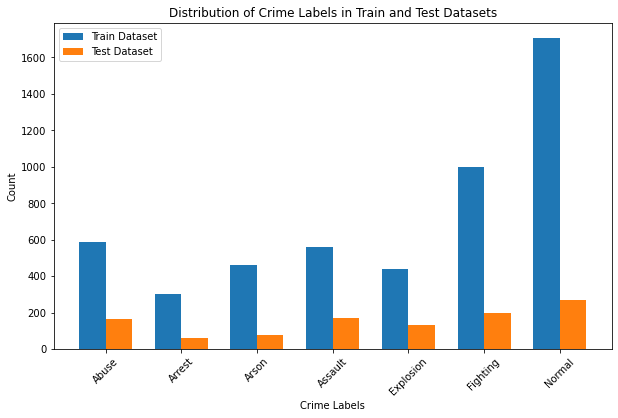

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def distribution(train_dataset, test_dataset):
    # Initialize the datasets

    # Basic dataset information
    print(f"Total number of videos in training set: {len(train_dataset)}")
    print(f"Total number of videos in testing set: {len(test_dataset)}")

    # Label distribution for training dataset
    train_label_counts = {label: 0 for label in DATA_SOURCE.keys()}
    for label in train_dataset._labels:
        label_str = label  # Assuming label is already a string
        train_label_counts[label_str] += 1

    # Label distribution for testing dataset
    test_label_counts = {label: 0 for label in DATA_SOURCE.keys()}
    for label in test_dataset._labels:
        label_str = label  # Assuming label is already a string
        test_label_counts[label_str] += 1

    labels = list(train_label_counts.keys())
    train_counts = list(train_label_counts.values())
    test_counts = list(test_label_counts.values())

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    plt.figure(figsize=(10, 6))
    
    # Plotting the bars
    plt.bar(x - width/2, train_counts, width, label='Train Dataset')
    plt.bar(x + width/2, test_counts, width, label='Test Dataset')

    # Labeling
    plt.xlabel('Crime Labels')
    plt.ylabel('Count')
    plt.title('Distribution of Crime Labels in Train and Test Datasets')
    plt.xticks(x, labels, rotation=45)
    plt.legend()

    plt.show()

distribution(train_dataset, test_dataset)


In [32]:
test_dataset

In [33]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [34]:
num_classes = 7

CNN MODEL - MODEL 1

Epoch : 1...
Train Loss: 1385997.3157, Train Accuracy: 0.2893
Test Loss: 2406.7987, Test Accuracy: 0.3887
Epoch : 2...
Train Loss: 2384.4687, Train Accuracy: 0.3838
Test Loss: 2818.0888, Test Accuracy: 0.2967
Epoch : 3...
Train Loss: 45339.3473, Train Accuracy: 0.2824
Test Loss: 3762.9570, Test Accuracy: 0.2770
Epoch : 4...
Train Loss: 1230.0991, Train Accuracy: 0.3871
Test Loss: 328.2582, Test Accuracy: 0.4808
Epoch : 5...
Train Loss: 476.0276, Train Accuracy: 0.4349
Test Loss: 369.2075, Test Accuracy: 0.5042


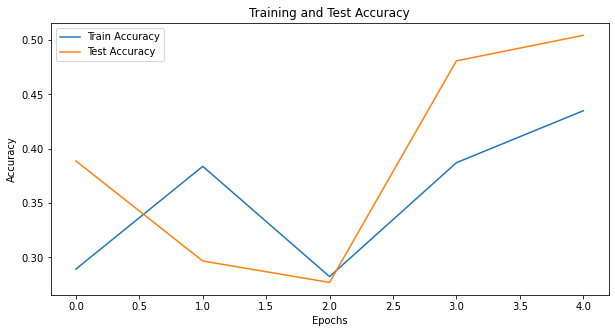

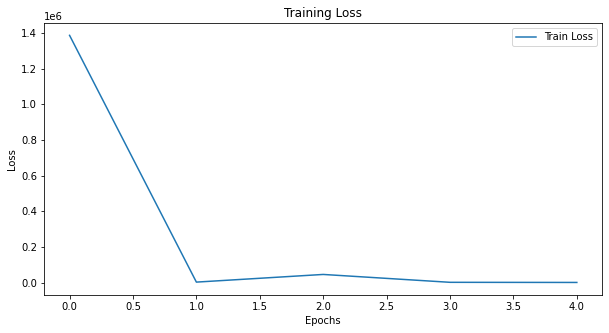

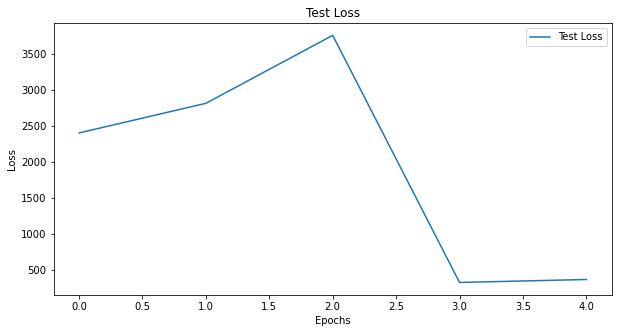

In [46]:
#ONLY CNN
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.max_pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.max_pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.max_pool3 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 7)  # Adjust output size according to your number of classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.max_pool2(x)
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.max_pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.fc2(x)  # Final fully connected layer with output for each class
        return x


# Instantiate the model
cnn_model = CNNModel()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

# Define your optimizer and scheduler
optimizer = optim.Adam(cnn_model.parameters(), lr=0.1)

# Define your criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Assuming train_loader and test_loader are defined
NUM_EPOCHS = 5
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(NUM_EPOCHS):
    cnn_model.train()
    total_correct_train = 0
    total_train_loss = 0

    print(f"Epoch : {epoch + 1}...")

    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Ensure label is a 1D tensor of class indices
        label = label.squeeze()

        preds = cnn_model(data)
        loss = criterion(preds, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_correct_train += (preds.argmax(dim=1) == label).sum().item()

        if batch_idx % 10 == 0:
            print(f"Loss: {loss.item()}, Batch: {batch_idx + 1}/{len(train_loader)}", end="\r")

    # Calculate average loss and accuracy for this epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_correct_train / len(train_loader.dataset)

    train_loss_history.append(avg_train_loss)
    train_accuracy_history.append(train_accuracy)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Save the model after each epoch if needed
    # torch.save(cnn_model.state_dict(), f"cnn_model_epoch_{epoch + 1}.pth")


    # Testing
    cnn_model.eval()
    total_correct_test = 0
    total_test_loss = 0

    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            # Ensure label is a 1D tensor of class indices
            label = label.squeeze()

            preds = cnn_model(data)
            loss = criterion(preds, label)

            total_test_loss += loss.item()
            total_correct_test += (preds.argmax(dim=1) == label).sum().item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = total_correct_test / len(test_loader.dataset)

    test_loss_history.append(avg_test_loss)
    test_accuracy_history.append(test_accuracy)

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.title("Training and Test Accuracy")
plt.plot(train_accuracy_history, label="Train Accuracy")
plt.plot(test_accuracy_history, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Training Loss")
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Test Loss")
plt.plot(test_loss_history, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


EVALUATION METRICS OF MODEL 1

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cnn_model.eval()
total_correct_test = 0
total_test_loss = 0
predictions = []
true_labels = []

with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)

        # Ensure label is a 1D tensor of class indices
        label = label.squeeze()

        preds = cnn_model(data)
        loss = criterion(preds, label)

        total_test_loss += loss.item()
        total_correct_test += (preds.argmax(dim=1) == label).sum().item()
        predictions.extend(preds.argmax(dim=1).cpu().numpy())
        true_labels.extend(label.cpu().numpy())

avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = total_correct_test / len(test_loader.dataset)

test_loss_history.append(avg_test_loss)
test_accuracy_history.append(test_accuracy)
    
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5042
Precision: 0.5124
Recall: 0.5042
F1 Score: 0.4733


Hybrid Model - Model 2

In [4]:
class CrimeModelCNN(nn.Module):
    def __init__(self):
        super(CrimeModelCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding="same")
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.max_pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding="same")
        self.max_pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding="same")
        self.max_pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28 * 256, 256)
        self.dropout4 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.max_pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.max_pool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.max_pool3(x)
        x = self.dropout3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout4(x)
        return x

In [5]:
class CrimeModelLSTM(nn.Module):
    def __init__(self):
        super(CrimeModelLSTM, self).__init__()
        self.lstm1 = nn.LSTM(1, 8, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(8, 8, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(8, 4)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = self.fc(x)
        x = self.dropout(x)
        return x

In [6]:
class CrimeModel(nn.Module):
    def __init__(self):
        super(CrimeModel, self).__init__()
        self.cnn = CrimeModelCNN()
        self.lstm = CrimeModelLSTM()
        self.fc = nn.Linear(260, 7)  # Adjust the input size according to your concatenation axis

    def forward(self, x):
        x_cnn = x
        x_lstm = torch.reshape(x, (x.shape[0], RESOLUTION * RESOLUTION, 1))
        x_cnn = self.cnn(x_cnn)
        x_lstm = self.lstm(x_lstm)
        x_combined = torch.cat((x_cnn, x_lstm), dim=1)
        x = self.fc(x_combined)
#         return F.softmax(x, dim=1)
        return x

In [22]:
num_classes = 7  # Adjust this to the number of classes in your dataset
model = CrimeModel()

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [21]:
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): DataParallel(
    (module): DataParallel(
      (module): CrimeModel(
        (cnn): CrimeModelCNN(
          (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (leaky_relu): LeakyReLU(negative_slope=0.1)
          (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (dropout1): Dropout(p=0.25, inplace=False)
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (dropout2): Dropout(p=0.25, inplace=False)
          (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (dropout3): Dropout(p=0.4, inplace=False)
          (flatten): Flatten(start_dim=1, end_dim=-1)
          (fc1): Linear(in_features=200704, out_features=256, b

In [73]:
NUM_EPOCHS = 5

For model 2 learning rate = 0.01

In [74]:
for g in optimizer.param_groups:
    g['lr'] = 0.01

In [75]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Example scheduler


Epoch : 1...
Train Loss: 46.0934, Train Accuracy: 0.2796
Test Loss: 1.8381, Test Accuracy: 0.3484
Epoch : 2...
Train Loss: 1.6930, Train Accuracy: 0.4721
Test Loss: 1.2881, Test Accuracy: 0.5531
Epoch : 3...
Train Loss: 1.2943, Train Accuracy: 0.5939
Test Loss: 1.1895, Test Accuracy: 0.6094
Epoch : 4...
Train Loss: 1.0381, Train Accuracy: 0.6782
Test Loss: 0.9873, Test Accuracy: 0.6977
Epoch : 5...
Train Loss: 0.9354, Train Accuracy: 0.7345
Test Loss: 1.0508, Test Accuracy: 0.6695


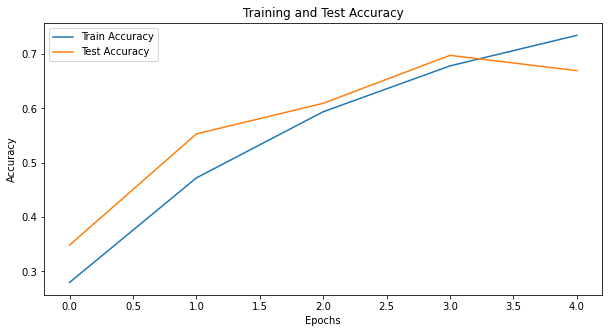

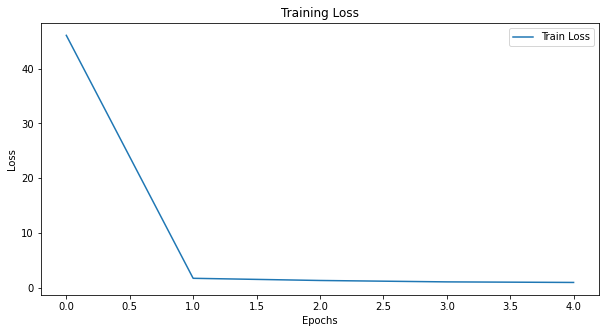

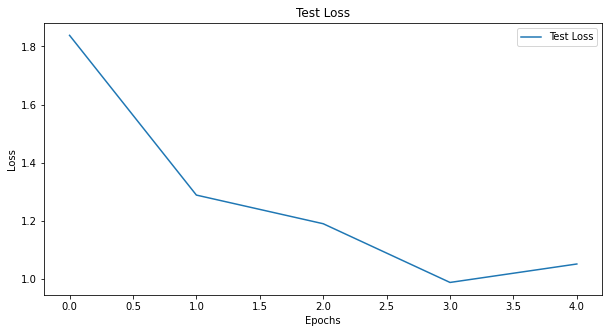

In [76]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_correct_train = 0
    total_train_loss = 0

    print(f"Epoch : {epoch + 1}...")

    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)

        # Ensure label is a 1D tensor of class indices
        label = label.squeeze()

        preds = model(data)
        loss = criterion(preds, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_correct_train += (preds.argmax(dim=1) == label).sum().item()

        if batch_idx % 10 == 0:
            print(f"Loss: {loss.item()}, Batch: {batch_idx + 1}/{len(train_loader)}", end="\r")

    # Calculate average loss and accuracy for this epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_correct_train / len(train_loader.dataset)

    train_loss_history.append(avg_train_loss)
    train_accuracy_history.append(train_accuracy)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Save the model after each epoch
    torch.save(model.state_dict(), f"crime_model_epoch_{epoch + 1}.pth")
    
    scheduler.step()

    # Testing
    model.eval()
    total_correct_test = 0
    total_test_loss = 0

    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            # Ensure label is a 1D tensor of class indices
            label = label.squeeze()

            preds = model(data)
            loss = criterion(preds, label)

            total_test_loss += loss.item()
            total_correct_test += (preds.argmax(dim=1) == label).sum().item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = total_correct_test / len(test_loader.dataset)

    test_loss_history.append(avg_test_loss)
    test_accuracy_history.append(test_accuracy)

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.title("Training and Test Accuracy")
plt.plot(train_accuracy_history, label="Train Accuracy")
plt.plot(test_accuracy_history, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Training Loss")
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Test Loss")
plt.plot(test_loss_history, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
def model_train_test(model,lr):
    import torch
    import torch.nn as nn
    import matplotlib.pyplot as plt
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model = nn.DataParallel(model)
    model.to(device)

    NUM_EPOCHS = 5

    for g in optimizer.param_groups:
        g['lr'] = lr*0.1



    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 

    train_loss_history = []
    train_accuracy_history = []
    test_loss_history = []
    test_accuracy_history = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_correct_train = 0
        total_train_loss = 0

        print(f"Epoch : {epoch + 1}...")

        for batch_idx, (data, label) in enumerate(train_loader):
            data = data.to(device)
            label = label.to(device)

            # Ensure label is a 1D tensor of class indices
            label = label.squeeze()

            preds = model(data)
            loss = criterion(preds, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_correct_train += (preds.argmax(dim=1) == label).sum().item()

            if batch_idx % 10 == 0:
                print(f"Loss: {loss.item()}, Batch: {batch_idx + 1}/{len(train_loader)}", end="\r")

        # Calculate average loss and accuracy for this epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_correct_train / len(train_loader.dataset)

        train_loss_history.append(avg_train_loss)
        train_accuracy_history.append(train_accuracy)

        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Save the model after each epoch
        torch.save(model.state_dict(), f"crime_model_epoch_{epoch + 1}.pth")

        scheduler.step()

        # Testing
        model.eval()
        total_correct_test = 0
        total_test_loss = 0

        with torch.no_grad():
            for data, label in test_loader:
                data = data.to(device)
                label = label.to(device)

                # Ensure label is a 1D tensor of class indices
                label = label.squeeze()

                preds = model(data)
                loss = criterion(preds, label)

                total_test_loss += loss.item()
                total_correct_test += (preds.argmax(dim=1) == label).sum().item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = total_correct_test / len(test_loader.dataset)

        test_loss_history.append(avg_test_loss)
        test_accuracy_history.append(test_accuracy)

        print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Plotting the accuracies
    plt.figure(figsize=(10, 5))
    plt.title("Training and Test Accuracy")
    plt.plot(train_accuracy_history, label="Train Accuracy")
    plt.plot(test_accuracy_history, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.title("Training Loss")
    plt.plot(train_loss_history, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.title("Test Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

For model 2 Learning rate = 0.001

Epoch : 1...
Train Loss: 1.4197, Train Accuracy: 0.4990
Test Loss: 1.0655, Test Accuracy: 0.6526
Epoch : 2...
Train Loss: 0.7071, Train Accuracy: 0.7816
Test Loss: 0.6315, Test Accuracy: 0.8131
Epoch : 3...
Train Loss: 0.3296, Train Accuracy: 0.8966
Test Loss: 0.5404, Test Accuracy: 0.8545
Epoch : 4...
Train Loss: 0.1633, Train Accuracy: 0.9521
Test Loss: 0.6241, Test Accuracy: 0.8582
Epoch : 5...
Train Loss: 0.1016, Train Accuracy: 0.9697
Test Loss: 0.6925, Test Accuracy: 0.8526


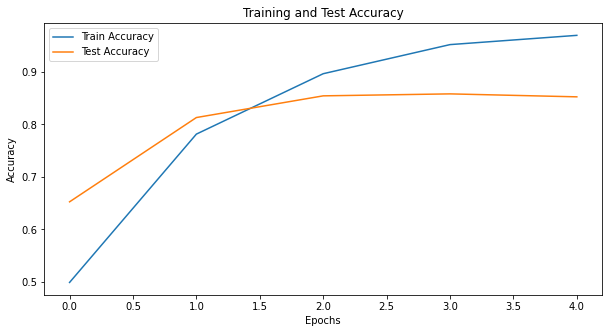

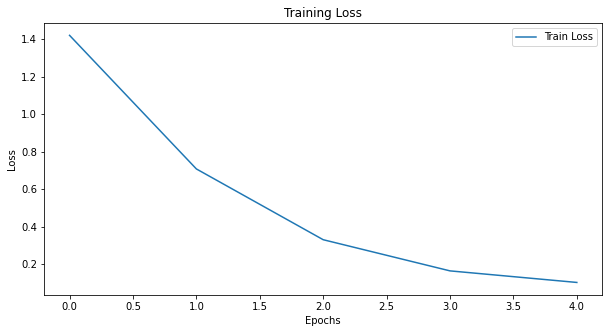

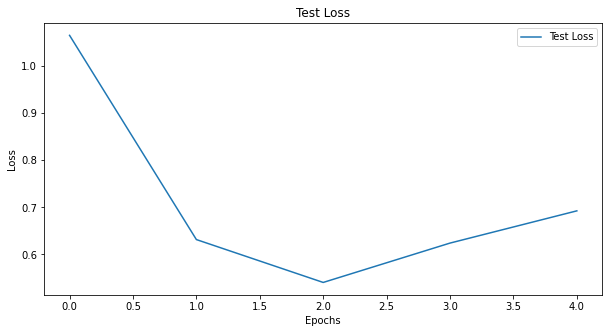

In [24]:
#for lr=0.001

model_train_test(model,0.001)

Evaulation of model 2

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_ = torch.nn.DataParallel(model)

# Load the state dictionary
model_.load_state_dict(torch.load('crime_model_epoch_5.pth'))

model_.eval()
total_correct_test = 0
total_test_loss = 0
predictions = []
true_labels = []
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)

        # Ensure label is a 1D tensor of class indices
        label = label.squeeze()

        preds = model_(data)
        loss = criterion(preds, label)

        total_test_loss += loss.item()
        total_correct_test += (preds.argmax(dim=1) == label).sum().item()
        predictions.extend(preds.argmax(dim=1).cpu().numpy())
        true_labels.extend(label.cpu().numpy())

avg_test_loss = total_test_loss / len(test_loader)
test_accuracy = total_correct_test / len(test_loader.dataset)

#test_loss_history.append(avg_test_loss)
#test_accuracy_history.append(test_accuracy)
    
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8526
Precision: 0.8605
Recall: 0.8526
F1 Score: 0.8518


In [33]:
import pickle

# Save the model
with open('model_1.pkl', 'wb') as file:
    pickle.dump(model, file)

In [34]:
with open('model_1.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [89]:
loaded_model.eval()

DataParallel(
  (module): DataParallel(
    (module): CrimeModel(
      (cnn): CrimeModelCNN(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (leaky_relu): LeakyReLU(negative_slope=0.1)
        (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (dropout1): Dropout(p=0.25, inplace=False)
        (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (dropout2): Dropout(p=0.25, inplace=False)
        (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (max_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (dropout3): Dropout(p=0.4, inplace=False)
        (flatten): Flatten(start_dim=1, end_dim=-1)
        (fc1): Linear(in_features=200704, out_features=256, bias=True)
        (dropout4): Dropout(p=0.5, inplace=Fal

In [25]:
model_ = torch.nn.DataParallel(model)

# Load the state dictionary
model_.load_state_dict(torch.load('crime_model_epoch_5.pth'))

# Set the model to evaluation mode if needed
#model_.eval()

<All keys matched successfully>

In [2]:
!pip install pillow

In [4]:
from PIL import Image

# Load the existing image
image_path = 'chart.png'  # Path to your existing image
image = Image.open('D:\capstone\download (3).png')

# Resize the image to 8x6 inches with 100 DPI (dots per inch)
# This converts the inches to pixels. 8*100 = 800 pixels wide, 6*100 = 600 pixels high
new_size = (800, 600)
resized_image = image.resize(new_size, Image.ANTIALIAS)

# Save the resized image
resized_image.save('cnn_train_test_acc.png')

# Optionally display the resized image
# res.show()
